In [1105]:
import pandas as pd
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import random

In [2]:
# Read the CSV files
games = pd.read_csv("data/nfl-big-data-bowl-2024/games.csv")
players = pd.read_csv("data/nfl-big-data-bowl-2024/players.csv")

# Calculate height in inches
players['height'] = players['height'].str.extract(r'(\d+)').astype(int) * 12 + players['height'].str.extract(r'-(\d+)').astype(int)

# Select columns
players = players[['displayName', 'nflId', 'height', 'weight', 'position']]

plays = pd.read_csv("data/nfl-big-data-bowl-2024/plays.csv")
tackles = pd.read_csv("data/nfl-big-data-bowl-2024/tackles.csv")

# Read and combine tracking data for all weeks
tracking = pd.concat([pd.read_csv(f"data/nfl-big-data-bowl-2024/tracking_week_{week}.csv") for week in range(1, 10)])
ball_tracking = tracking.loc[tracking['nflId'].isna()][["gameId", "frameId" "playId", "x", "y"]].rename({"x" : "ball_x", "y" : "ball_y"}, axis = 1)

In [751]:
tackles.query("gameId == 2022090800 & playId ==  56")

,gameId,playId,nflId,tackle,assist,forcedFumble,pff_missedTackle
840,2022090800,56,43294,1,0,0,0


In [148]:
ball_tracking

,gameId,frameId,playId,ball_x,ball_y
484,2022090800,1,56,85.050003,33.810001
485,2022090800,2,56,83.150002,34.830002
486,2022090800,3,56,81.739998,35.590000
487,2022090800,4,56,80.139999,36.450001
488,2022090800,5,56,79.290001,36.930000
...,...,...,...,...,...
1150018,2022110700,40,3787,26.219999,19.680000
1150019,2022110700,41,3787,26.320000,19.610001
1150020,2022110700,42,3787,26.389999,19.559999
1150021,2022110700,43,3787,26.450001,19.520000


In [1120]:
def euclidean_distance(x1, y1, x2, y2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

class play:
    def __init__(self, game_id, play_id):
        self.play = plays.query("gameId == @game_id & playId ==  @play_id")
        self.ball_carry_id = ball_carrier = self.play.ballCarrierId.reset_index(drop =1)[0]
        self.tracking_df = tracking.query("gameId == @game_id & playId ==  @play_id")
        self.ball_track = ball_tracking.query("gameId == @game_id & playId ==  @play_id")
        self.tackle_oppurtunities = tackles.query("gameId == @game_id & playId ==  @play_id")
        self.num_frames = max(self.tracking_df.frameId)
        self.eop = self.get_end_of_play_location()
        self.tracking_refined = {frame_id : self.refine_tracking(frame_id = frame_id) for frame_id in range(1, self.num_frames)}
        self.tracking_refined_stratified = {frame_id : {player_type : self.tracking_refined.get(frame_id).loc[(self.tracking_refined.get(frame_id)['type'] == player_type)] 
                                                        for player_type in ["Offense", "Defense", "Carrier"]} for frame_id in range(1, self.num_frames)}
        self.images_10 = self.get_all_grid_features(N = 10)
    
    def get_end_of_play_location(self):
        ball_carrier = self.ball_carry_id
        last_frame = self.num_frames
        end_of_play_carrier = self.tracking_df.query("nflId == @ball_carrier & frameId == @last_frame")
        return end_of_play_carrier[["frameId", "x", "y"]].rename({"x" : "eop_x", "y" : "eop_y"}, axis = 1)
    
    def get_end_of_play_matrix(self, N):
        tackles_attempt_mat = np.zeros((int(120/N), math.ceil(54/N)))
        for item in list(zip(self.eop.eop_x, self.eop.eop_y)):
            tackles_attempt_mat[int(item[0]/N), int(item[1]/N)] = 1
        return tackles_attempt_mat
    
    def refine_tracking(self, frame_id):
        current_positions = self.tracking_df.query("frameId == @frame_id").merge(players, on = "nflId", how = "left")
        current_positions['type'] = current_positions['position'].apply(
            lambda x: "Offense" if x in ["QB", "TE", "WR", "G", "OLB", "RB", "C", "FB"] else "Defense")
        current_positions['type'] = current_positions.apply(lambda row: 'Ball' if pd.isna(row['nflId']) else row['type'], axis=1)
        current_positions.loc[current_positions.nflId == self.ball_carry_id, 'type'] = "Carrier"
        current_positions['dir_rad'] = np.radians(current_positions['dir']) # degrees point in y direction
        current_positions['Sx'] = current_positions['s'] * np.cos(current_positions['dir_rad'])
        current_positions['Sy'] = current_positions['s'] * np.sin(current_positions['dir_rad'])
        current_positions['Ax'] = current_positions['a'] * np.cos(current_positions['dir_rad'])
        current_positions['Ay'] = current_positions['a'] * np.sin(current_positions['dir_rad'])
        return current_positions[['nflId', 'x', 'y', 'Sx', 'Sy', 'Ax', 'Ay', 's', 'a', 'dis', 'o', 'dir', 'dir_rad', 'height', 'weight', 'type']]
    
    def get_grid_features(self, frame_id, N, matrix_form = True):
        stratified_dfs = self.tracking_refined_stratified[frame_id]
        grid_features = pd.DataFrame()
        return_mat = np.zeros((24, len(list(range(0, 120, N))), len(list(range(0, 54, N)))))
        for x_low in list(range(0, 120, N)):
            for y_low in list(range(0, 54, N)):
                off_df = stratified_dfs["Offense"]
                def_df = stratified_dfs["Defense"]
                ball_df = stratified_dfs["Carrier"]
                x_high = x_low + N
                y_high = y_low + N

                    # Extract relevant subsets of data
                off_subset = off_df[(off_df['x'] >= x_low) & (off_df['x'] < x_high) & (off_df['y'] >= y_low) & (off_df['y'] < y_high)]
                def_subset = def_df[(def_df['x'] >= x_low) & (def_df['x'] < x_high) & (def_df['y'] >= y_low) & (def_df['y'] < y_high)]
                ball_subset = ball_df[(ball_df['x'] >= x_low) & (ball_df['x'] < x_high) & (ball_df['y'] >= y_low) & (ball_df['y'] < y_high)]

                # Calculate statistics using vectorized operations
                current_offensive_player_density = len(off_subset)
                current_defensive_player_density = len(def_subset)
                current_ballcarrier_player_density = len(ball_subset)

                offense_directional_vector = np.cos(off_df['dir'] * (np.pi / 180)) * (x_low + N/2 - off_df['x']) + np.sin(off_df['dir'] * (math.pi / 180)) * (y_low + N/2 - off_df['y'])
                defense_directional_vector = np.cos(def_df['dir'] * (np.pi / 180)) * (x_low + N/2 - def_df['x']) + np.sin(def_df['dir'] * (math.pi / 180)) * (y_low + N/2 - def_df['y'])

                velocities_offensive_toward_point = off_df['s'] * offense_directional_vector
                velocities_defensive_toward_point = def_df['s'] * defense_directional_vector
                
                acceleration_offensive_toward_point = off_df['a'] * offense_directional_vector
                acceleration_defensive_toward_point = def_df['a'] * defense_directional_vector

                distance_offense_from_point = np.sqrt((off_df['x'] - (x_low + N/2))**2 + (off_df['y'] - (y_low + N/2))**2)
                distance_defensive_from_point = np.sqrt((def_df['x'] - (x_low + N/2))**2 + (def_df['y'] - (y_low + N/2))**2)

                velocities_ballcarrier_toward_point = ball_df['s'] * (np.cos(ball_df['dir'] * (math.pi / 180)) * (x_low + N/2 - ball_df['x']) +
                                                                    np.sin(ball_df['dir'] * (math.pi / 180)) * (y_low + N/2 - ball_df['y']))
                acceleration_ballcarrier_toward_point = ball_df['a'] * (np.cos(ball_df['dir'] * (math.pi / 180)) * (x_low + N/2 - ball_df['x']) +
                                                                        np.sin(ball_df['dir'] * (math.pi / 180)) * (y_low + N/2 - ball_df['y']))
                distance_ballcarrier_from_point = np.sqrt((ball_df['x'] - (x_low + N/2))**2 + (ball_df['y'] - (y_low + N/2))**2)
                ret = pd.DataFrame({'grid_id': [f"{x_low} {y_low}"],
                                                    'off_density': [current_offensive_player_density],
                                                    'def_density': [current_defensive_player_density],
                                                    'ballcarrier_density': [current_ballcarrier_player_density],
                                                    'off_velocity_mean': [np.mean(velocities_offensive_toward_point)],
                                                    'off_velocity_sum': [np.sum(velocities_offensive_toward_point)],
                                                    'off_velocity_std': [np.std(velocities_offensive_toward_point)],
                                                    'def_velocity_mean': [np.mean(velocities_defensive_toward_point)],
                                                    'def_velocity_sum': [np.sum(velocities_defensive_toward_point)],
                                                    'def_velocity_std': [np.std(velocities_defensive_toward_point)],
                                                    'ballcarrier_velocity': [velocities_ballcarrier_toward_point.values[0]],
                                                    'off_acc_mean': [np.mean(acceleration_offensive_toward_point)],
                                                    'off_acc_sum': [np.sum(acceleration_offensive_toward_point)],
                                                    'off_acc_std': [np.std(acceleration_offensive_toward_point)],
                                                    'def_acc_mean': [np.mean(acceleration_defensive_toward_point)],
                                                    'def_acc_sum': [np.sum(acceleration_defensive_toward_point)],
                                                    'def_acc_std': [np.std(acceleration_defensive_toward_point)],
                                                    'ballcarrier_acc': [acceleration_ballcarrier_toward_point.values[0]],
                                                    'off_distance_mean': [np.mean(distance_offense_from_point)],
                                                    'off_distance_sum': [np.sum(distance_offense_from_point)],
                                                    'off_distance_std': [np.std(distance_offense_from_point)],
                                                    'def_distance_mean': [np.mean(distance_defensive_from_point)],
                                                    'def_distance_sum': [np.sum(distance_defensive_from_point)],
                                                    'def_distance_std': [np.std(distance_defensive_from_point)],
                                                    'ballcarrier_distance': [distance_ballcarrier_from_point.values[0]]})
                if matrix_form:
                    return_mat[:, int(x_low/N), int(y_low/N)] = np.array(ret.drop(['grid_id'], axis = 1).iloc[0])
                else:
                    grid_features = pd.concat([grid_features, ret])
        if matrix_form:
            return return_mat
        else:
            return grid_features

    def get_all_grid_features(self, N):
        all_features = {}
        for frame_id in range(1, self.num_frames):
            all_features.update({frame_id : self.get_grid_features(frame_id = frame_id, N = N, matrix_form = True)})
        return(all_features)
    
    def predict_tackle_distribution(self, model):
        if len(self.tracking_refined.get(1).type.unique()) != 4:
            raise KeyError("None-Complete Tracking Data") # if not offense, defense, ball and carrier in play
        outputs = []
        pred_df = pd.DataFrame()
        for frame_id in range(1, self.num_frames):
            image = self.images_10[frame_id]
            image = image[None, :, :, :]
            output = model(torch.FloatTensor(image)).detach().numpy()
            for x in range(output.shape[1]):
                for y in range(output.shape[2]):
                    new_row = pd.DataFrame({"x" : [x*model.N+model.N/2], "y" : [y*model.N+model.N/2], "prob" : [output[0, x, y]], "frameId" : [frame_id]})
                    pred_df = pd.concat([pred_df, new_row], axis = 0)
        return(pred_df)
                


class TackleAttemptDataset:

    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        self.num_samples = len(images)
    
    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        image = torch.FloatTensor(self.images[idx])
        label = torch.FloatTensor(self.labels[idx])
        return image, label

In [1121]:
play_object = play(game_id=2022101300, play_id=826)
pred = play_object.predict_tackle_distribution(model)
pred.to_csv("game_2022101300_play_826.csv")

In [1122]:
pred

,x,y,prob,frameId
0,5.0,5.0,6.982699e-04,1
0,5.0,15.0,2.621851e-04,1
0,5.0,25.0,1.060860e-04,1
0,5.0,35.0,4.406978e-03,1
0,5.0,45.0,4.508632e-04,1
...,...,...,...,...
0,115.0,15.0,1.329080e-02,163
0,115.0,25.0,8.169993e-03,163
0,115.0,35.0,1.113655e-03,163
0,115.0,45.0,2.651591e-07,163


In [926]:
play_object = play(game_id=2022090800, play_id=56)
play_object.predict_tackle_distribution(model)
# off_df = play_object.tracking_refined_stratified[10]["Offense"].sort_values('nflId')
#def_df = play_object.tracking_refined_stratified[10]["Defense"].sort_values('nflId')
#carrier_df = play_object.tracking_refined_stratified[10]["Carrier"].sort_values('nflId')

#off_def_distance_matrix = np.sqrt(np.sum((off_df[['x', 'y']].values[:, np.newaxis] - def_df[['x', 'y']].values) ** 2, axis=2))
#off_def_speed_matrix = np.sqrt(np.sum((off_df[['Sx', 'Sy']].values[:, np.newaxis] - def_df[['Sx', 'Sy']].values) ** 2, axis=2))
#off_carrier_distance_matrix = np.sqrt(np.sum((off_df[['Sx', 'Sy']].values[:, np.newaxis] - carrier_df[['Sx', 'Sy']].values) ** 2, axis=2))
#off_carrier_distance_matrix

array([[2.2675394 ],
       [3.3125967 ],
       [3.53173428],
       [1.70018837],
       [1.90526287],
       [2.84264589],
       [1.03630961],
       [6.2637773 ]])

In [1106]:
# Do for only t = 10 to start

images = []
labels = []
N = 10
for row in tqdm(range(3000)):
    play_row = plays.iloc[row,]
    play_object = play(game_id=play_row.gameId, play_id=play_row.playId)
    frame_id = random_value = random.randint(1, play_object.num_frames)
    if play_object.num_frames <= frame_id:
        continue # if not n frames happened
    if len(play_object.tracking_refined.get(1).type.unique()) != 4:
        continue # if not offense, defense, ball and carrier in play
    images.append(play_object.get_grid_features(frame_id = frame_id, N = N))
    labels.append(play_object.get_end_of_play_matrix(N = N))
train_data = TackleAttemptDataset(images = images, labels = labels)
train_dataloader = DataLoader(train_data, batch_size=250, shuffle=True)

100%|██████████| 3000/3000 [31:04<00:00,  1.61it/s]


In [1107]:
tackle_dataset[0][0].shape

torch.Size([24, 12, 6])

In [1108]:
tackle_dataset = TackleAttemptDataset(images = images, labels = labels)
train_data, val_data = torch.utils.data.random_split(tackle_dataset, [0.9, 0.1])

In [1109]:
class TackleNet(nn.Module):
    def __init__(self, N, nvar):
        super(TackleNet, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(nvar, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 20, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(20, 10, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(10, 20, kernel_size=3, padding=1)
        # self.pool = nn.MaxPool2d(3, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(math.ceil(120/N)*math.ceil(54/N)*20, 128)
        self.fc2 = nn.Linear(128, math.ceil(120/N)*math.ceil(54/N))
        self.N = N
        
    def forward(self, x):
        # Input shape: (batch_size, 24, 12, 6)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        
        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        
        # Apply softmax to ensure the output sums to 1 along the channel dimension (12*6)
        x = x.view(-1, math.ceil(120/self.N), math.ceil(54/self.N))
        
        return x
    
def plot_predictions(prediction_output, true):
    fig, axs = plt.subplots(8, 8, figsize=(16, 16))

    # Flatten the 8x8 grid of subplots to a 1D array for easier indexing
    axs = axs.flatten()

    # Loop through the 64 images and display each in a subplot
    for i in range(64):
        image = prediction_output[i].detach().numpy()
        true_image = true[i].detach().numpy()
        axs[i].imshow(image, cmap='Reds', interpolation='none')
        axs[i].axis('off')  # Turn off the axis for each subplot
        axs[i].set_title(f"Image {i + 1}")
        axs[i].grid()
        x_max = true_image.shape[0]
        y_max = true_image.shape[1]
        for k in range(x_max):
            for l in range(y_max):
                # axs[i].text(l, k, f'{image[k, l]:.1f}', ha='center', va='center', color='black')
                if true_image[k, l] == 1:
                    axs[i].plot(l, k, 'ro', markersize=5, color='blue')               
    # Adjust spacing between subplots to make them look better
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.show()

Epoch: 0
Train Loss: 0.062340423464775085
Validation Loss: 0.06282280385494232
Validation Accuracy: 0.19444444444444445
Epoch: 1
Train Loss: 0.054676175117492676
Validation Loss: 0.05642903968691826
Validation Accuracy: 0.16666666666666666
Epoch: 2
Train Loss: 0.049806416034698486
Validation Loss: 0.050515174865722656
Validation Accuracy: 0.25
Epoch: 3
Train Loss: 0.04696658253669739
Validation Loss: 0.049202870577573776
Validation Accuracy: 0.2222222222222222
Epoch: 4
Train Loss: 0.04560792073607445
Validation Loss: 0.04727707430720329
Validation Accuracy: 0.2222222222222222
Epoch: 5
Train Loss: 0.04401190206408501
Validation Loss: 0.046767640858888626
Validation Accuracy: 0.3611111111111111
Epoch: 6
Train Loss: 0.043572813272476196
Validation Loss: 0.04627330228686333
Validation Accuracy: 0.3055555555555556
Epoch: 7
Train Loss: 0.04253334552049637
Validation Loss: 0.04587025195360184
Validation Accuracy: 0.3333333333333333
Epoch: 8
Train Loss: 0.041597265750169754
Validation Loss: 0.

/var/folders/xs/5ps3sp7d651c8whk_0_xk6580000gn/T/ipykernel_99667/54619312.py:55: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axs[i].plot(l, k, 'ro', markersize=5, color='blue')


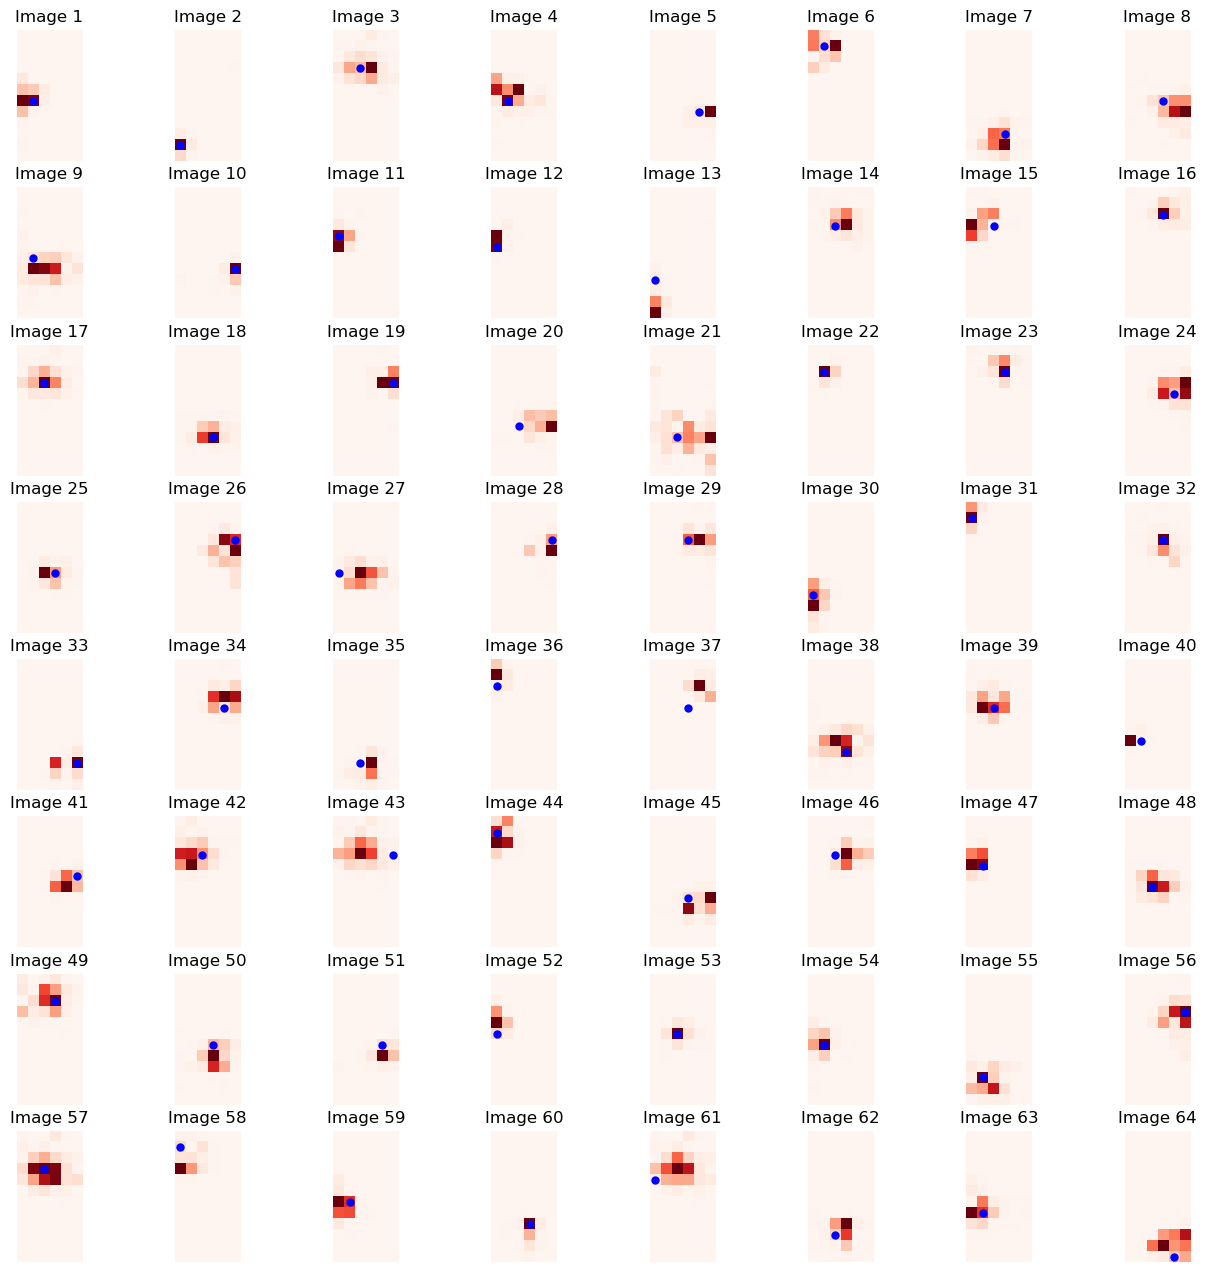

Validation Loss: 0.04332030937075615
Validation Accuracy: 0.3333333333333333


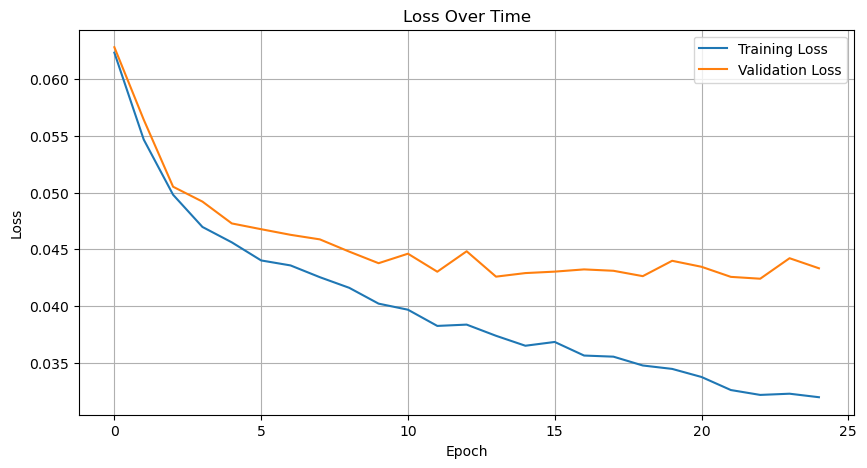

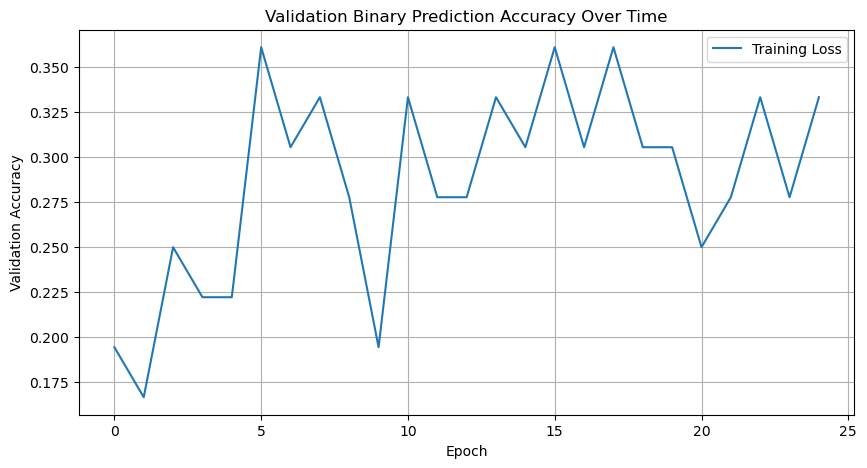

In [1111]:
# Create Data Loader
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64)

# Define the loss function (you can choose an appropriate loss function for your task)
criterion = nn.BCELoss()

# Create Model
model = TackleNet(N = 10, nvar = 24)

# Define the optimizer (e.g., Stochastic Gradient Descent)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 25

losses = []
val_losses = []
val_accuracy = []
for epoch in range(num_epochs):
    for X_batch, y_batch in train_dataloader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output.flatten(), y_batch.flatten())
        loss.backward()
        optimizer.step()

    # After training, you can use the model to make predictions
    predictions = []
    true_labels = []
    with torch.no_grad():  # Disable gradient computation for inference
        for X_batch, y_batch in train_dataloader:
            outputs = model(X_batch)
            predictions.append(outputs.flatten())
            true_labels.append(y_batch.flatten())
        predictions = torch.cat(predictions, dim=0) 
        true_labels = torch.cat(true_labels, dim=0) 
        loss = criterion(predictions, true_labels)
        losses.append(loss.detach())
        print(f"Epoch: {epoch}")
        print(f"Train Loss: {loss}")
    predictions = []
    true_labels = []
    prediction_correct = []
    with torch.no_grad():  # Disable gradient computation for inference
        i = 0
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            if (i == 0) & (epoch == num_epochs-1):
                plot_predictions(outputs, y_batch)
            predictions.append(outputs.flatten())
            true_labels.append(y_batch.flatten())
            i += 1
        predictions = torch.cat(predictions, dim=0) 
        true_labels = torch.cat(true_labels, dim=0) 
        val_loss = criterion(predictions, true_labels)
        val_losses.append(val_loss.detach())
        max_values, _ = torch.max(outputs, dim=-1, keepdim=True)
        max_values, _ = torch.max(max_values, dim=-2, keepdim=True)
        masks = torch.where(outputs == max_values, 1, 0)
        equivalence_tensor = torch.all(y_batch == masks, dim=0)
        equivalence_values = torch.all(equivalence_tensor, dim=1).numpy().tolist()
        max_values, _ = torch.max(outputs, dim=-1, keepdim=True)
        max_values, _ = torch.max(max_values, dim=-2, keepdim=True)
        masks = torch.where(outputs == max_values, 1, 0)
        equivalence_values = np.all(masks.detach().numpy() == y_batch.detach().numpy(), axis=(1, 2)).tolist()
        prediction_correct.extend(equivalence_values)
    acc = sum(prediction_correct)/len(prediction_correct)
    val_accuracy.append(acc)
    print(f"Validation Loss: {val_loss}")
    print(f"Validation Accuracy: {acc}")
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(val_accuracy, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Binary Prediction Accuracy Over Time')
plt.legend()
plt.grid(True)
plt.show()

0.8733974358974359


[False False False False False False False False False False]


In [1063]:
play_object = play(game_id=2022090800, play_id=56)
play_object.predict_tackle_distribution(model = model).shape

torch.Size([21, 12, 6])

In [1126]:
class play_cache:
    def __init__(self, play_df):
        self.plays_zip = list(zip(play_df.gameId, play_df.playId))
        self.all_play = self.calculate_all_play_objects()

    def calculate_all_play_objects(self):
        print("Calculating all play_objects.")
        print("-----------------------------")
        all_plays = dict()
        for game_id, play_id in tqdm(self.plays_zip):
            all_plays[f"{game_id}_{play_id}"] = play(game_id, play_id)
        return all_plays 
    
ex = play_cache(play_df = plays)

Calculating all play_objects.
-----------------------------


  0%|          | 3/12486 [00:38<44:27:07, 12.82s/it]


KeyboardInterrupt: 